# Сессия 4

---

## Демонстрация работы api в формате ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:f}'.format})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_columns=50

import warnings
warnings.filterwarnings("ignore")

### Написание API

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.options.display.max_columns=50

class API():
    def attributor(attribute, claster, df):
        # to_datetime метод, который автоматически преобразует дату в првавильный формат
        df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]] = pd.to_datetime(
            df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].stack(), format='%Y-%m-%d %H:%M:%S').unstack()
        # Создание столбца с уникальными датами, это необходимо для работы модели строящей времянные ряды
        df["tpep_pickup_datetime"] = df["tpep_pickup_datetime"].map(lambda x: x.date())
        # Удаление дубликатов при помощи drop_duplicates
        df = df.drop_duplicates(subset=['tpep_pickup_datetime'])
        # Сброс индексов
        df.reset_index(drop=True, inplace=True)

        df = df.sort_values(by='tpep_pickup_datetime')
        # df.reset_index(inplace=True)
        # Создания копии колонки с датой
        df['datecopy'] = df['tpep_pickup_datetime']
        # Установка временных индексов вместо обычных
        df.set_index('datecopy', inplace=True)
        # Привести индексы к формату datetime
        df.index = pd.to_datetime(df.index)
        # Создание не большого набора дыннх для дальнейших пердсказаний атрибута
        chi = df[df['BMCLUSTS'] == claster]
        chi = chi[[attribute]]
        # Переимоновывание атрибута
        chi = chi.rename(columns={attribute: "co2"})
        # Автоматическое заполнение пропусков дат (без этого мадоль не будет работать)
        y = chi.asfreq('D')
        # Заполнение пустых значений нулями
        y.fillna(0, inplace=True)

        # 'MS' группирует месячные данные
        y = y['co2']

        # bfill значит, что нужно использовать значение до заполнения пропущенных значений
        y = y.fillna(y.bfill())
        # Построение графика распределения
        y.plot(figsize=(15, 6))
        plt.show()
        return y

    def modelfitter(y, steps, date, mod):
        results = mod
        print(results.summary().tables[1])
        # Предсказание для выявление средней квадратичной ошибки
        pred_dynamic = results.get_prediction(start=pd.to_datetime(y.index[0]), dynamic=True, full_results=True)
        pred_dynamic_ci = pred_dynamic.conf_int()

        # Извлечь прогнозируемые и истинные значения временного ряда
        y_forecasted = pred_dynamic.predicted_mean
        y_truth = y[y.index[0]:]  # Вычислить среднеквадратичную ошибку
        mse = ((y_forecasted - y_truth) ** 2).mean()
        print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

        # Предсказание по выбраной дате
        pred_dynamic = results.get_prediction(start=pd.to_datetime(date), dynamic=True, full_results=True)
        pred_dynamic_ci = pred_dynamic.conf_int()
        y_forecasted = pred_dynamic.predicted_mean

        # Получить прогноз на 1000 шагов вперёд
        pred_uc = results.get_forecast(steps=steps)
        # Получить интервал прогноза
        return [pred_uc, y_forecasted]

In [3]:
#Стиль графика
plt.style.use('dark_background')
df = pd.read_csv("ses3ready.csv", encoding="utf-8-sig")

Для демонстрации работы api в этом формате данные будут введены в ручную, для более полного раскрытия возможностей api воспользуйтесь приложением

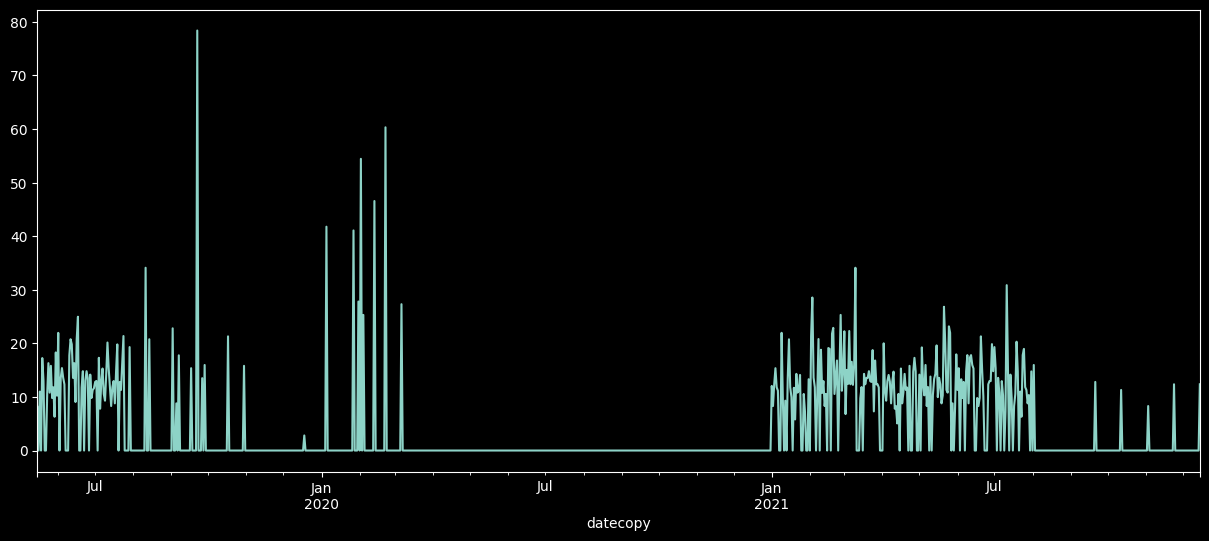

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6684      0.019    -34.855      0.000      -0.706      -0.631
ar.L2         -0.3354      0.019    -17.964      0.000      -0.372      -0.299
ma.L1         -1.0000     38.225     -0.026      0.979     -75.919      73.919
ar.S.L10      -0.7339      0.018    -41.682      0.000      -0.768      -0.699
ar.S.L20      -0.3363      0.019    -17.649      0.000      -0.374      -0.299
ma.S.L10      -1.0000     94.311     -0.011      0.992    -185.847     183.847
sigma2        70.0520   6689.405      0.010      0.992    -1.3e+04    1.32e+04
The Mean Squared Error of our forecasts is 77.07


In [4]:
import pickle
#Ввод данных для настройки и импорта модели вручную
selected_cluster = '(Дачники) Не большое количество людей, которые очень долго ездят на длинные дистанции и платят много денег'
#Выбранный кластер
selected_cluster = df[df["clustername"] == selected_cluster]["BMCLUSTS"].values[0]
#Путь к нужной модели
strfmodel = "models/"+"amountC" + str(selected_cluster) +".sav"
#Загрузка модели
loaded_model = pickle.load(open(strfmodel, 'rb'))

#Применение функций API с выбраными параметрами
y = API.attributor("total_amount", selected_cluster, df)
preds = API.modelfitter(y, 800, "2024",loaded_model)

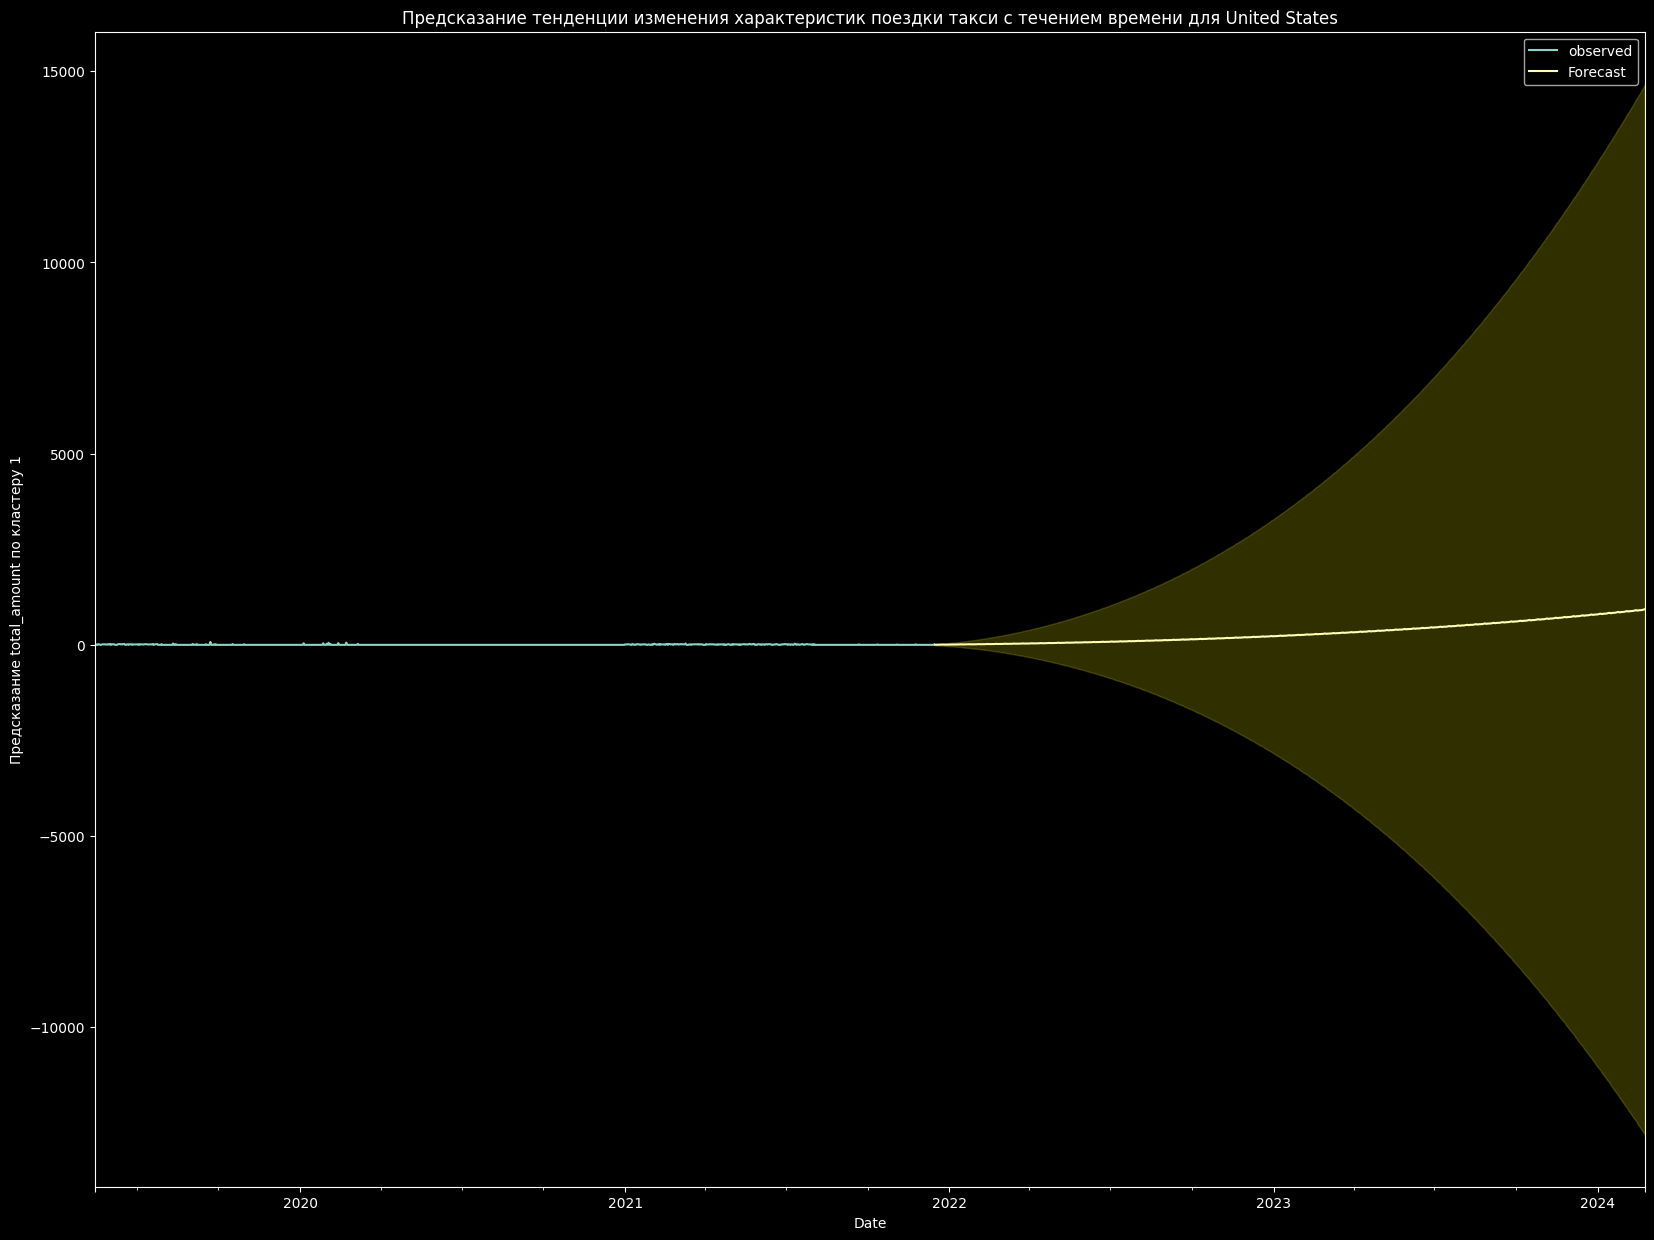

In [5]:
# Простая визуализация предсказания временных рядов
# Построение графика осуществляется на основе характеристики forecast (это итоговое предсказание)
pred_ci = preds[0].conf_int()

fig, ax = plt.subplots()
#Ось графика с отрисованной линией
ax = y.plot(label='observed', figsize=(20, 15))
#Индексы для построения графиков
preds[0].predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
#Заголовки
ax.set_ylabel(f"Предсказание total_amount по кластеру {selected_cluster}")
ax.set_title('Предсказание тенденции изменения характеристик поездки такси с течением времени для United States')
plt.legend()